<a href="https://colab.research.google.com/github/Mifekmk/SkillTreePython-DeepLearning/blob/main/04.Paper-with-code/ch04_03_Generative_Model_DCGAN_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch04.03 Generative Model - DCGAN

* 날짜: 2022-08-09
* 이름: 김민규

## 학습내용
    - 딥러닝 생성모델에 대해 이해한다.
    - Deep Convolutional Generative Adversarial Networks 를 구현한다.

> https://arxiv.org/pdf/1406.2661.pdf



## 실습
---

### | **모델 구현**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-02.PNG?raw=true' width=800>
</p>

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils

def build_gene(z_dim=64, img_shape=(28,28,1)):
  h, w, c = img_shape
  # 길이가 (z_dim) 벡터 
  z = layers.Input(shape=[z_dim])

  y = layers.Dense( int(w/4)*int(h/4)*8 , activation='relu')(z)
  y = layers.Reshape( [int(w/4),int(h/4),8] )(y)
  y = layers.BatchNormalization()(y)
  y = layers.Conv2DTranspose(16, kernel_size=3, padding='same', strides=2, activation='relu')(y)
  y = layers.BatchNormalization()(y)

  # 크기가 img_shape = (h, w, c) 텐서
  y = layers.Conv2DTranspose(c, kernel_size=3, padding='same', strides=2, activation='sigmoid')(y)
  
  return models.Model(z, y, name='Generator')

def build_disc(img_shape=(28,28,1)):
  x = layers.Input(shape=img_shape)
  y = layers.Conv2D(16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
  y = layers.Dropout(.5)(y)
  y = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(y)
  y = layers.Dropout(.5)(y)
  y = layers.Flatten()(y)
  y = layers.Dense(128, activation='relu')(y)
  y = layers.Dropout(.5)(y)
  y = layers.Dense(1, activation='sigmoid')(y)
  return models.Model(x, y, name='Discriminator')

def build_gan(z_dim, img_shape):
  gene = build_gene(z_dim, img_shape)
  disc = build_disc(img_shape)

  z = layers.Input(shape=[z_dim])
  fake_img = gene(z)
  logit = disc(fake_img)
  return models.Model(z, logit, name='GAN')

gan = build_gan(128, (32,32,3))
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128)]             0         
                                                                 
 Generator (Functional)      (None, 32, 32, 3)         67747     
                                                                 
 Discriminator (Functional)  (None, 1)                 267489    
                                                                 
Total params: 335,236
Trainable params: 335,188
Non-trainable params: 48
_________________________________________________________________


(1, 128) (1, 32, 32, 3)


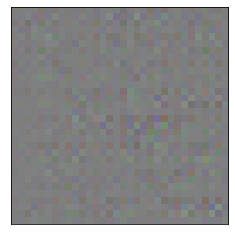

[[0.506355]]


In [12]:
import matplotlib.pyplot as plt

g = build_gene(128, (32,32,3))
d = build_disc((32,32,3))

z = tf.random.normal([1, 128])
fake_img = g.predict(z)
print(z.shape, fake_img.shape)
plt.imshow(fake_img[0]);plt.xticks([]);plt.yticks([])
plt.show()
logit = d.predict(fake_img)
print(logit)

### **| 학습**
<p  align='center'>
<img src ='https://github.com/yebiny/SkillTreePython-DeepLearning/blob/main/imgs/ch0403-01.PNG?raw=true' width=600>
</p>